# Supplementary Info Figures: 8 & 9 class model plots

This notebook will reproduce the supplementary info figures S1 and S2 from *A Novel Heuristic Method for Detecting Overfit in Unsupervised Classification of Climate Models*, E. Boland et al. 2023 (doi to follow). This plots the properties of 8 and 9 class GMMs fit to UK-ESM historical Southern Ocean data 2001-2018, following Jones et al. 2019 (https://doi.org/10.1029/2018JC014629). This requires the files data/\[ensemble member\]/\[nclass\]/avg.obj, created by running Step2_fitmodels.ipynb.

Please attribute any plots or code from this notebook using the DOI from Zenodo: to come

Updated Mar 2023
E Atkinson & E Boland [emmomp@bas.ac.uk](email:emmomp@bas.ac.uk)

In [5]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import matplotlib.path as mpath

import os
import pickle

import cluster_utils as flt

In [3]:
model_folder = 'model'
n_classes = [8,9]
ids = ['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2', 'r4i1p1f2', 'r5i1p1f3', 'r6i1p1f3', 'r7i1p1f3', 'r8i1p1f2', 'r9i1p1f2', 'r10i1p1f2']
mask = np.load('data/mask.npy', allow_pickle=True)
levs= np.load('data/levs.npy', allow_pickle=True)

In [4]:
# Load fronts
fronts=['saf','pf','saccf','sbdy']
front_data={}
for front in fronts:
    front_data[front]=np.loadtxt('data/fronts/{}_kim.txt'.format(front))

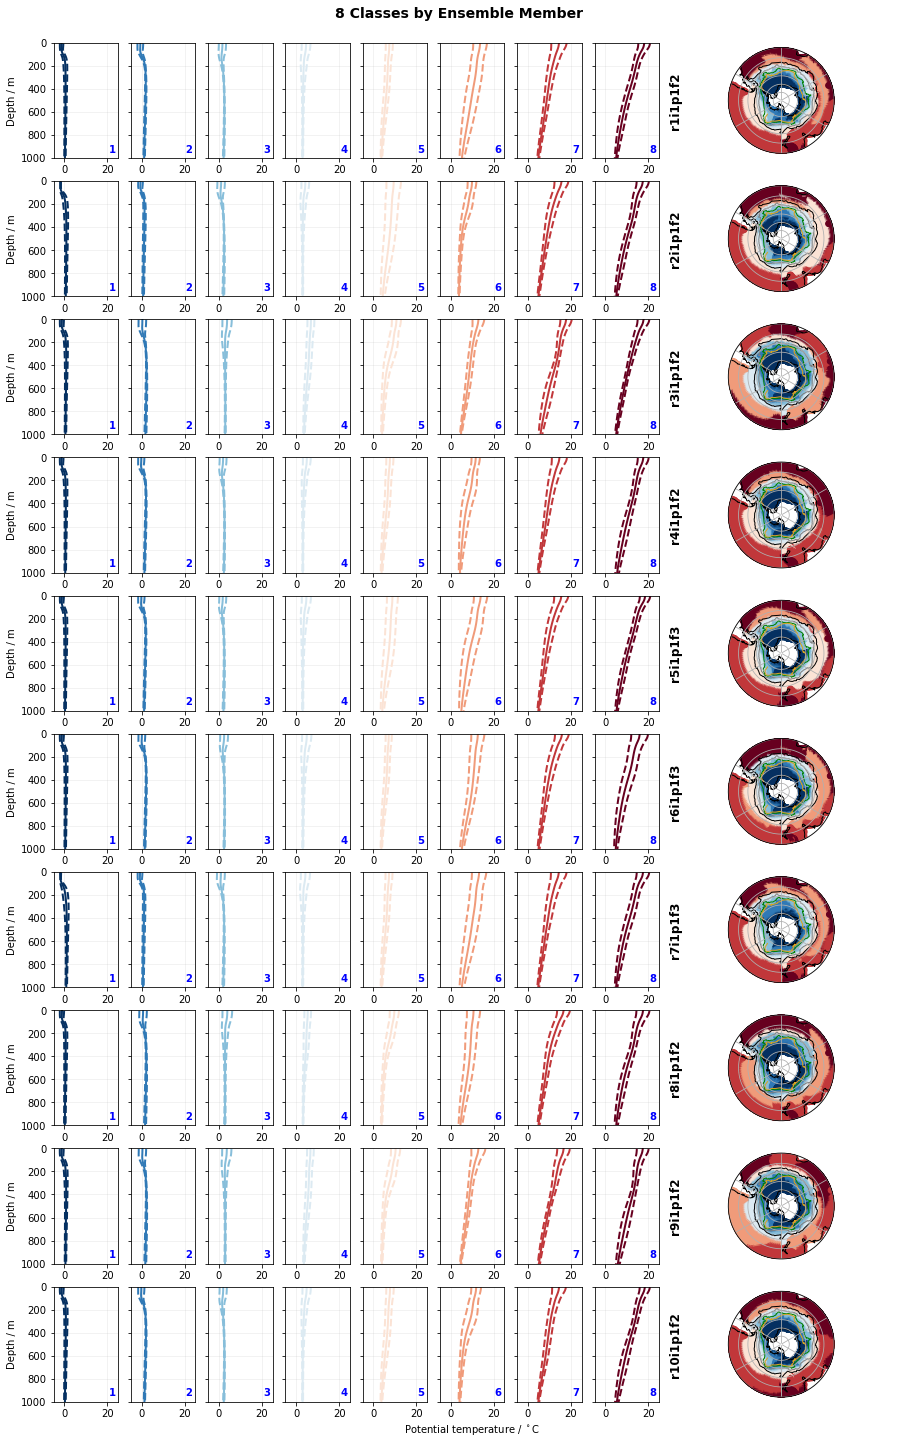

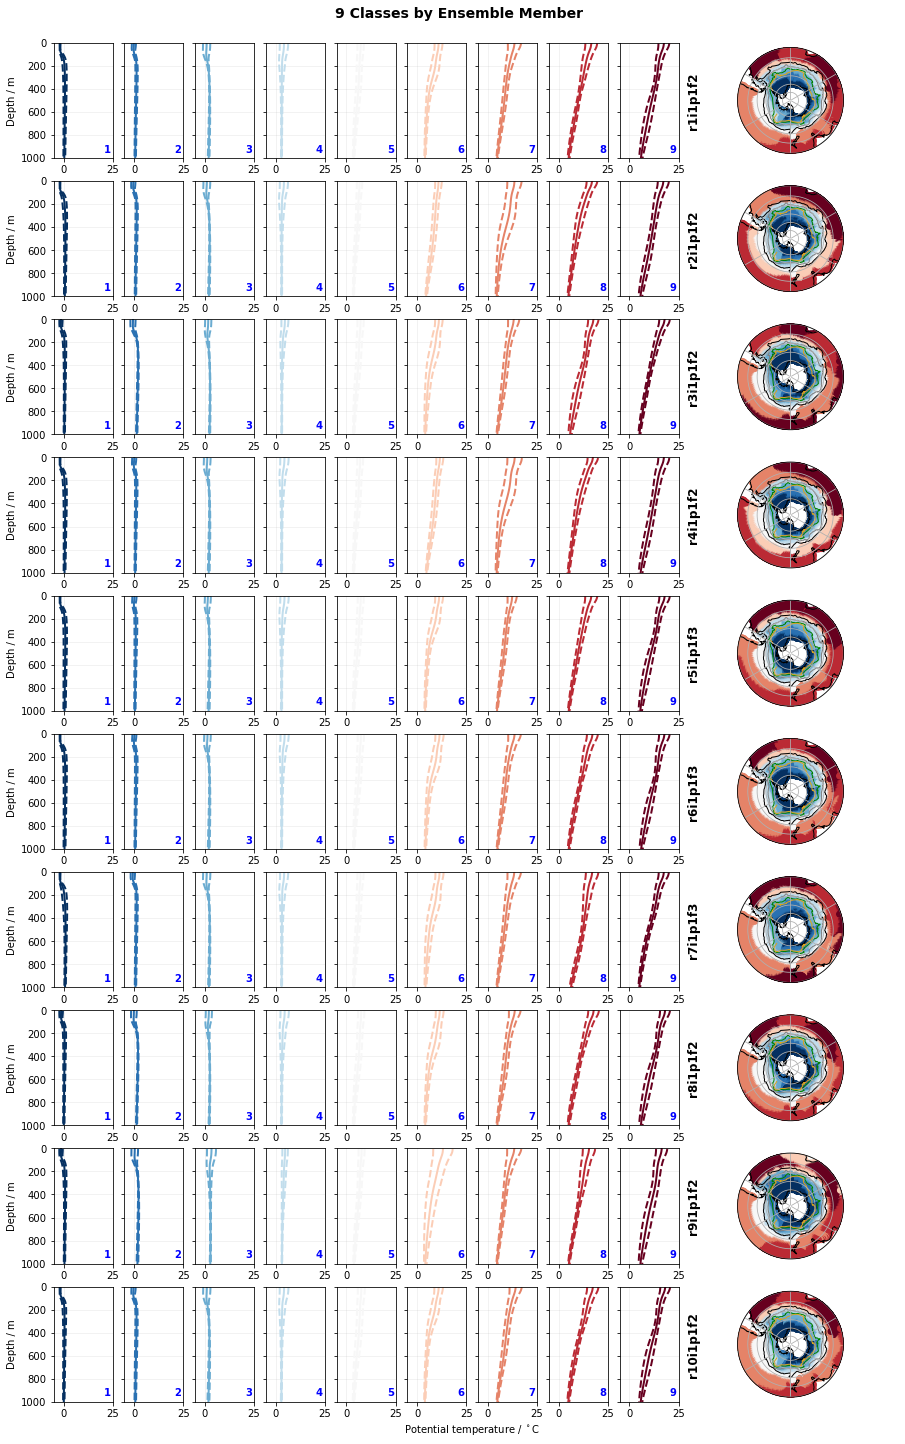

In [16]:
proj = ccrs.SouthPolarStereo()
front_colors=['black','grey','green',(218/256,165/256,32/256)]

# compute a circle in axes coordinates, 
# which we can use as a boundary for the map.
theta = np.linspace(0, 2*np.pi, 100)
center = [0.5, 0.5]
radius = 0.46   # 0.46 corresponds to roughly 30S Latitude
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

for iin,nclass in enumerate(n_classes):
    
    fig=plt.figure(figsize=(15,25))
    colormap = plt.get_cmap('RdBu_r', nclass)
    
    for im,m_id in enumerate(ids):
        
        # Load data and sort by mean profile temperature
        path='{}/{}/{}'.format(model_folder, m_id, nclass)
        data=xr.open_dataset('{}/class.nc'.format(path)) 
        with open('{}/avg_prof.obj'.format(path), 'rb') as file:
            ref_profiles = pickle.load(file)
        inds=flt.temp_sort(None, ref_profiles, True)
        classes=flt.reorder(data,inds)
        
        ax=plt.subplot2grid((10,nclass+3),(im,nclass),colspan=3,projection=proj)    
        
        CS=ax.scatter(classes.lon,classes.lat,c=flt.modal_classes(classes['class'],dims=['time']),cmap=colormap,transform=ccrs.PlateCarree())
        for indf,front in enumerate(fronts):
            ax.plot(front_data[front][:,0], front_data[front][:,1], lw = 1, ls='-', label=front.upper(),color=front_colors[indf],transform=ccrs.PlateCarree())
        ax.set_boundary(circle, transform=ax.transAxes)

        # Add features
        ax.gridlines()
        ax.coastlines()
        
        for nn in range(0,nclass):
            ax=plt.subplot2grid((10,nclass+3),(im,nn),colspan=1)            
            
            if nn == nclass-1:
                ax.annotate(m_id,xy=(1.15,0.5),xycoords=ax.transAxes,fontsize=12,fontweight='bold',\
                     rotation='vertical',va='center')
            ax.text(0.85,0.05,str(nn+1),fontweight='bold',fontsize=10,color='b',transform=ax.transAxes)

            ax.plot(ref_profiles[inds[nn]]['mean'],levs,color=colormap(nn),lw=2)
            ax.plot(ref_profiles[inds[nn]]['mean']+ref_profiles[inds[nn]]['std'],levs,linestyle='--',color=colormap(nn),lw=2)
            ax.plot(ref_profiles[inds[nn]]['mean']-ref_profiles[inds[nn]]['std'],levs,linestyle='--',color=colormap(nn),lw=2)
                                    
            ax.set_ylim([1000,0])
            ax.set_xlim(-5,25)
            ax.grid(alpha=0.2)
          # ax.set_xlabel('Temperature (°C)')
            if nn==0:
                ax.set_ylabel('Depth / m')     
            else:
                ax.set_yticklabels('')

    plt.suptitle('{} Classes by Ensemble Member'.format(nclass),fontsize=14,fontweight='bold',y=0.9)

    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel('Potential temperature / ${}^\circ$C')    

    plt.savefig('figures/{}class_byensemble.pdf'.format(nclass),bbox_inches='tight')